### **Vodafone Online Review Ingestion Pipeline Plus Exploratory Data Analysis (EDA)** {-}

Subject: MA5853 Project 1 <br>
Project: Project 008 - Vodafone Net Promoter Text Analysis <br>
Author: Nikki Fitzherbert

#### Part 1: Environment setup and data import {-}

In [1]:
# import every library that's required
import gensim
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import regex as re
import seaborn as sns
import spellchecker
import time

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from spellchecker import SpellChecker
from textblob import TextBlob
from wordcloud import WordCloud

# just a setting the author's system needs to plot matplotlib charts
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
%matplotlib inline

In [2]:
# load the desired English language model
# in this notebook, the transformer pipeline model is used. This is a larger and slower pipeline compared to the "sm",
#  "md" or "lg" models, which are optimised for use on a CPU, but is more accurate.
# see https://spacy.io/models/en for more information
import en_core_web_trf
nlp_trf = en_core_web_trf.load()
# the normal way to do it is:
#   import spacy
#   nlp_sm = en_core_web_sm.load()

# an alternative, and more commonly seen method (which doesn't work on the author's system) is:
# import spacy
# nlp = spacy.load("en_core_web_trf")
# see https://spacy.io/models/en for the english model performance statistics

In [3]:
# load the data
vodafone_reviews = pd.read_csv('vodafone_reviews1903.csv')

# examine the first few rows
vodafone_reviews.head()

,title,review,score
0,Vodaphone Almost Ruined My Life - Stolen Ident...,My email and password were part of a company d...,1
1,Misguided Sale,"Misguided SaleCouple of days ago, I was told t...",1
2,Worst network,Worst network for data in Australia. I used Vo...,1
3,Insurance contract with them is bulshit,They charged me for over a year a plan with in...,1
4,RECORD all your phonecalls with them when you ...,My parents and I have been with Vodafone for a...,1


#### Part 2: Preliminary EDA {-}

In [4]:
# define functions to classify each review into a NPS category
def create_nps_category(row):
    if row.score <= 3:
        category = 'Detractor'
    elif row.score == 4:
        category = 'Passive'
    else:
        category = 'Promoter'
    return category

def create_nps_class(row):
    if row.nps_category == 'Detractor':
        nps_class = -1
    elif row.nps_category == 'Passive':
        nps_class = 0
    else:
        nps_class = 1
    return nps_class


vodafone_reviews['nps_category'] = vodafone_reviews.apply(create_nps_category, axis=1)
vodafone_reviews['nps_class'] = vodafone_reviews.apply(create_nps_class, axis=1)

1    1502
2     110
3      55
4      82
5     154
dtype: int64
Detractor    1667
Passive        82
Promoter      154
dtype: int64


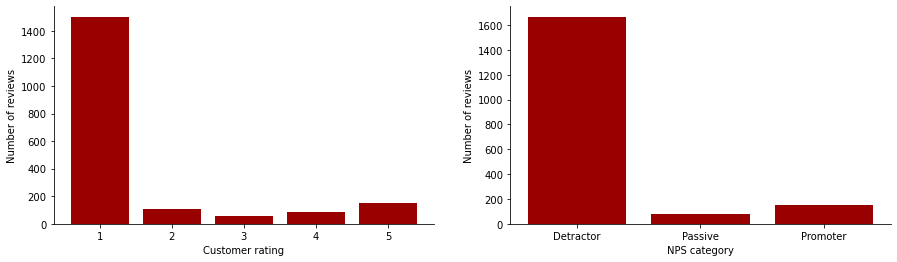

In [5]:
# plot the number of reviews by customer rating and NPS group
reviews = pd.value_counts(vodafone_reviews.score.values).sort_index()
reviews2 = pd.value_counts(vodafone_reviews.nps_category.values).sort_index()
print(reviews)
print(reviews2)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].bar(x=reviews.index, height=reviews.values, color='#990000')
axs[0].set_xlabel('Customer rating')
axs[0].set_ylabel('Number of reviews')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].bar(x=reviews2.index, height=reviews2.values, color='#990000')
axs[1].set_xlabel('NPS category')
axs[1].set_ylabel('Number of reviews')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False);

In [6]:
# combine the title and review columns together
vodafone_reviews['text'] = vodafone_reviews.apply(lambda x: x.title + '. ' + x.review, axis=1)

In [7]:
# calculate character and word lengths of the combined text and obtain some basic descriptive statistics
vodafone_reviews['text_num_chars'] = vodafone_reviews.text.apply(lambda x: len(x))
vodafone_reviews['text_num_words'] = vodafone_reviews.text.apply(lambda x: len(re.findall(r'\w+', x)))

descriptive_statistics = vodafone_reviews.describe()
descriptive_statistics

,score,nps_class,text_num_chars,text_num_words
count,1903.000000,1903.000000,1903.000000,1903.000000
mean,1.568576,-0.795060,592.800315,110.180767
std,1.238363,0.570052,471.563394,90.058977
min,1.000000,-1.000000,22.000000,3.000000
25%,1.000000,-1.000000,278.000000,50.500000
50%,1.000000,-1.000000,444.000000,82.000000
75%,1.000000,-1.000000,751.500000,140.000000
max,5.000000,1.000000,3602.000000,715.000000


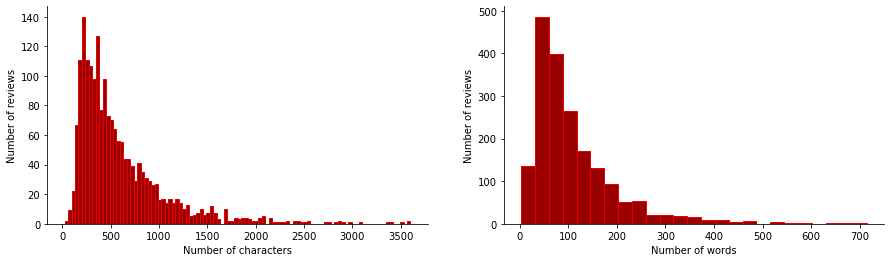

In [8]:
# plot the distribution of character and word lengths
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].hist(vodafone_reviews.text_num_chars, bins=100, edgecolor='#E60000', color='#990000')
axs[0].set_xlabel('Number of characters')
axs[0].set_ylabel('Number of reviews')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].hist(vodafone_reviews.text_num_words, bins=25, edgecolor='#E60000', color='#990000')
axs[1].set_xlabel('Number of words')
axs[1].set_ylabel('Number of reviews')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False);

In [9]:
# define a function to display a kde plot of any possible combination of nps category members
def plot_kde_plot(choice=1):
    if choice == 1:
        data = vodafone_reviews[vodafone_reviews.nps_category.isin(["Promoter", "Detractor"])]

        fig, axs = plt.subplots(1, 2, figsize=(15, 4))
        p = sns.kdeplot(ax=axs[0], data=data, x='text_num_chars', hue='nps_category', fill=True,
                        common_norm=False, palette=['#990000', '#4a4d4e'], legend=False)
        p.spines['right'].set_visible(False)
        p.spines['top'].set_visible(False)
        p.set_xlabel("Number of characters")
        # p.legend(labels=["Promoter", "Detractor"], title = "NPS category")

        p2 = sns.kdeplot(ax=axs[1], data=data, x='text_num_words', hue='nps_category', fill=True,
                         common_norm=False, palette=['#990000', '#4a4d4e'], legend=False)
        p2.spines['right'].set_visible(False)
        p2.spines['top'].set_visible(False)
        p2.set_xlabel("Number of words")
        p2.set_ylabel("")
        p2.legend(labels=["Promoter", "Detractor"], title="NPS category")
    elif choice == 2:
        fig, axs = plt.subplots(1, 2, figsize=(15, 4))
        p = sns.kdeplot(ax=axs[0], data=vodafone_reviews, x='text_num_chars', hue='nps_category', fill=True,
                        common_norm=False, palette=['#990000', '#4a4d4e', '#007c92'], legend=False)
        p.spines['right'].set_visible(False)
        p.spines['top'].set_visible(False)
        p.set_xlabel("Number of characters")
        # p.legend(labels=["Promoter", "Passive", "Detractor"], title="NPS category")

        p2 = sns.kdeplot(ax=axs[1], data=vodafone_reviews, x='text_num_words', hue='nps_category', fill=True,
                         common_norm=False, palette=['#990000', '#4a4d4e', '#007c92'], legend=False)
        p2.spines['right'].set_visible(False)
        p2.spines['top'].set_visible(False)
        p2.set_xlabel("Number of words")
        p2.set_ylabel("")
        p2.legend(labels=["Promoter", "Passive", "Detractor"], title="NPS category")
    elif choice == 3:
        data = vodafone_reviews[vodafone_reviews.nps_category.isin(["Promoter", "Passive"])]

        fig, axs = plt.subplots(1, 2, figsize=(15, 4))
        p = sns.kdeplot(ax=axs[0], data=data, x='text_num_chars', hue='nps_category', fill=True,
                        common_norm=False, palette=['#007c92', '#4a4d4e'], legend=False)
        p.spines['right'].set_visible(False)
        p.spines['top'].set_visible(False)
        p.set_xlabel("Number of characters")
        # p.legend(labels=["Promoter", "Passive"], title="NPS category")

        p2 = sns.kdeplot(ax=axs[1], data=data, x='text_num_words', hue='nps_category', fill=True,
                         common_norm=False, palette=['#007c92', '#4a4d4e'], legend=False)
        p2.spines['right'].set_visible(False)
        p2.spines['top'].set_visible(False)
        p2.set_xlabel("Number of words")
        p2.set_ylabel("")
        p2.legend(labels=["Promoter", "Passive"], title="NPS category")
    elif choice == 4:
        data = vodafone_reviews[vodafone_reviews.nps_category.isin(["Detractor", "Passive"])]

        fig, axs = plt.subplots(1, 2, figsize=(15, 4))
        p = sns.kdeplot(ax=axs[0], data=data, x='text_num_chars', hue='nps_category', fill=True,
                        common_norm=False, palette=['#990000', '#007c92'], legend=False)
        p.spines['right'].set_visible(False)
        p.spines['top'].set_visible(False)
        p.set_xlabel("Number of characters")
        # p.legend(labels=["Passive", "Detractor"], title="NPS category")

        p2 = sns.kdeplot(ax=axs[1], data=data, x='text_num_words', hue='nps_category', fill=True,
                         common_norm=False, palette=['#990000', '#007c92'], legend=False)
        p2.spines['right'].set_visible(False)
        p2.spines['top'].set_visible(False)
        p2.set_xlabel("Number of words")
        p2.set_ylabel("")
        p2.legend(labels=["Passive", "Detractor"], title="NPS category")
    else:
        print("Invalid selection.")

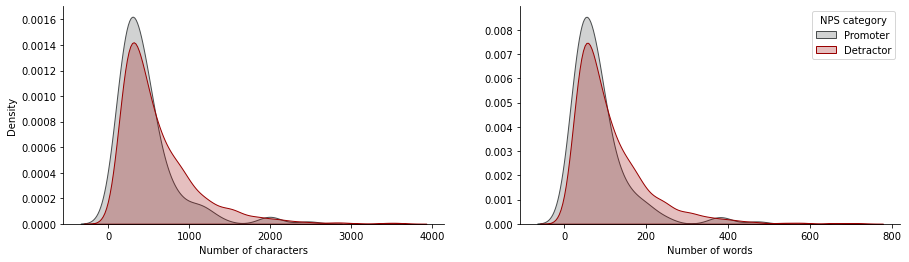

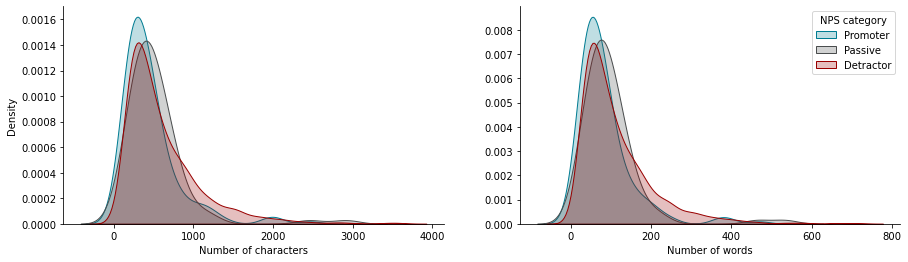

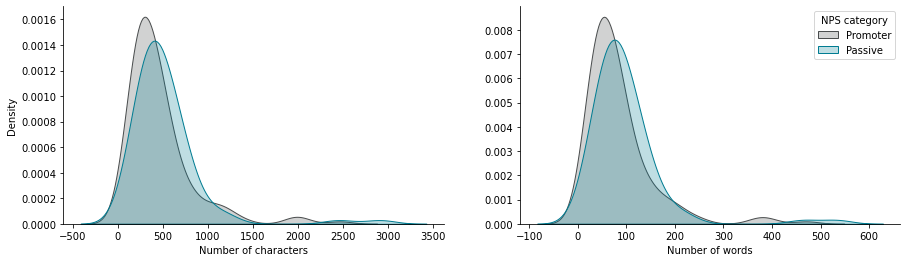

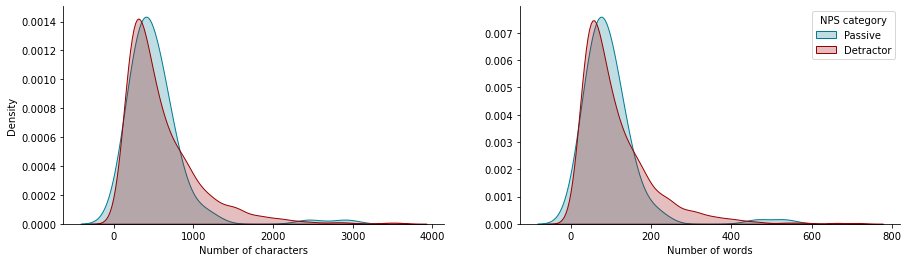

In [10]:
# 1 = detractor & promoter
# 2 = all
# 3 = promoter + passive
# 4 = detractor + passive
plot_kde_plot(choice=1)
plot_kde_plot(choice=2)
plot_kde_plot(choice=3)
plot_kde_plot(choice=4)

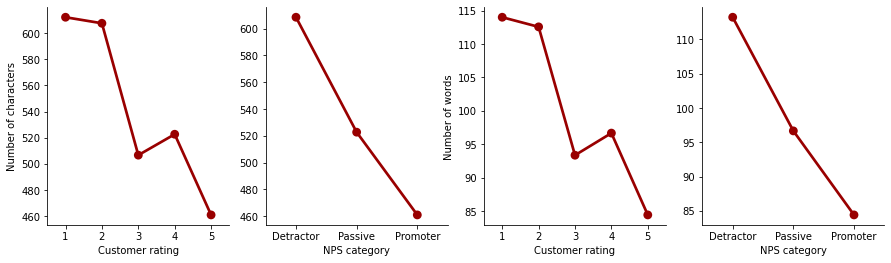

In [11]:
# an alternative representation using seaborn pointplots
fig, axs = plt.subplots(1, 4, figsize = (15, 4))
p = sns.pointplot(ax=axs[0], data=vodafone_reviews, x='score', y='text_num_chars', color='#990000', ci=None)
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)
p.set_xlabel("Customer rating")
p.set_ylabel("Number of characters")
p2 = sns.pointplot(ax=axs[1], data=vodafone_reviews, x='nps_category', y='text_num_chars', color='#990000', ci=None)
p2.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.set_xlabel("NPS category")
p2.set_ylabel("")
p3 = sns.pointplot(ax=axs[2], data=vodafone_reviews, x='score', y='text_num_words', color='#990000', ci=None)
p3.spines['right'].set_visible(False)
p3.spines['top'].set_visible(False)
p3.set_xlabel("Customer rating")
p3.set_ylabel("Number of words")
p4 = sns.pointplot(ax=axs[3], data=vodafone_reviews, x='nps_category', y='text_num_words', color='#990000', ci=None)
p4.spines['right'].set_visible(False)
p4.spines['top'].set_visible(False)
p4.set_xlabel("NPS category")
p4.set_ylabel("");

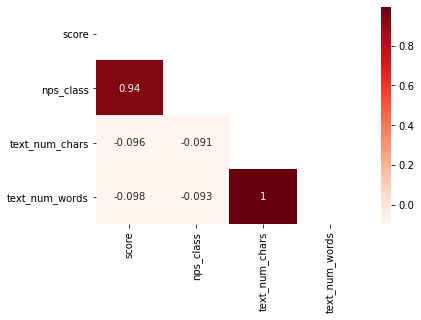

In [12]:
# calculate and plot the correlation between nps_category, customer rating, and title and review lengths
numeric_features = vodafone_reviews.loc[:, ['score', 'nps_class', 'text_num_chars', 'text_num_words']]
corr = numeric_features.corr()

fig, ax = plt.subplots(figsize = (6, 4))
mask = np.zeros_like(numeric_features.corr())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(numeric_features.corr(), mask=mask, ax=ax, annot=True, cmap='Reds');

In [13]:
# save all objects created thus far
def save_created_objects():
    object_names = [reviews, reviews2, descriptive_statistics, vodafone_reviews, numeric_features]
    reviews.to_csv('part2_reviews.csv', header=True, index=True)
    reviews2.to_csv('part2_reviews2.csv', header=True, index=True)
    descriptive_statistics.to_csv('part2_descriptive_statistics.csv', header=True, index=True)
    vodafone_reviews.to_csv('part2_vodafone_reviews.csv', header=True)
    numeric_features.to_csv('part2_numeric_features.csv', header=True)


save_created_objects()

#### Part 3: Data cleansing and normalisation pipeline {-}

In [14]:
# define a function to perform initial cleaning and pre-processing, including conversion to lower-case, correction of
#  various errors and idiosyncrasies, and spell-checking the text
def preprocess_review_text():
    # convert the text to lower-case
    vodafone_reviews['lower_text'] = vodafone_reviews.text.str.lower()

    # correct curly apostrophes
    vodafone_reviews.lower_text = vodafone_reviews.lower_text.str.replace("’", "'", regex=False)

    # correct encoding errors
    vodafone_reviews.lower_text = vodafone_reviews.lower_text.str.replace("â€™", "'", regex=False)
    vodafone_reviews.lower_text = vodafone_reviews.lower_text.str.replace("â€“", " ", regex=False)
    vodafone_reviews.lower_text = vodafone_reviews.lower_text.str.replace("\r", " ", regex=False)
    vodafone_reviews.lower_text = vodafone_reviews.lower_text.str.replace("\n", " ", regex=False)

    # create a dictionary of common expansions in the english language
    contractions_dict = {"can't": "can not",
                         "won't": "will not",
                         "don't": "do not",
                         "n't": " not",
                         "'m": " am",
                         "'ll": " will",
                         "'d": " would",
                         "'ve": " have",
                         "'re": " are",
                         "'s": ""}  # 's could be 'is' or could be possessive: it has no expansion

    # expand the contractions and add to dataframe as new variable
    exp_text = []
    for review in vodafone_reviews.lower_text:
        text = []
        for key, value in contractions_dict.items():
            if key in review:
                review = review.replace(key, value)
                text.append(review)
        exp_text.append(review)

    vodafone_reviews['clean_text'] = exp_text

    # remove punctuation and clean up the extra white space between words
    vodafone_reviews.clean_text = vodafone_reviews.clean_text.str.replace('[^\w\s]', ' ', regex=True)
    vodafone_reviews.clean_text = vodafone_reviews.clean_text.apply(lambda x: " ".join(x.split()))

    # create a vocabulary from the clean_text column
    def list_of_words(df, column):
        vocabulary = pd.DataFrame(columns=["words"])
        for i in range(len(df)):
            words = df[column].iloc[i]
            words = words.split(" ")
            vocabulary = vocabulary.append(pd.DataFrame(words, columns=["words"]))

        return vocabulary

    vocabulary = list_of_words(vodafone_reviews, "clean_text")
    vocabulary = vocabulary[vocabulary.words != ""]  # remove empty strings

    # initialise a spellchecker and check the unknown words
    spell = SpellChecker()

    unknown_words = spell.unknown(vocabulary.words.to_list())
    unknown_word_counts = vocabulary[vocabulary.words.isin(unknown_words)].value_counts()

    return vodafone_reviews, vocabulary, unknown_words, unknown_word_counts


vodafone_reviews, vocabulary, unknown_words, unknown_word_counts = preprocess_review_text()

In [15]:
vodafone_reviews.head()

,title,review,score,nps_category,nps_class,text,text_num_chars,text_num_words,lower_text,clean_text
0,Vodaphone Almost Ruined My Life - Stolen Ident...,My email and password were part of a company d...,1,Detractor,-1,Vodaphone Almost Ruined My Life - Stolen Ident...,1289,230,vodaphone almost ruined my life - stolen ident...,vodaphone almost ruined my life stolen identit...
1,Misguided Sale,"Misguided SaleCouple of days ago, I was told t...",1,Detractor,-1,Misguided Sale. Misguided SaleCouple of days a...,620,115,misguided sale. misguided salecouple of days a...,misguided sale misguided salecouple of days ag...
2,Worst network,Worst network for data in Australia. I used Vo...,1,Detractor,-1,Worst network. Worst network for data in Austr...,212,43,worst network. worst network for data in austr...,worst network worst network for data in austra...
3,Insurance contract with them is bulshit,They charged me for over a year a plan with in...,1,Detractor,-1,Insurance contract with them is bulshit. They ...,335,66,insurance contract with them is bulshit. they ...,insurance contract with them is bulshit they c...
4,RECORD all your phonecalls with them when you ...,My parents and I have been with Vodafone for a...,1,Detractor,-1,RECORD all your phonecalls with them when you ...,987,184,record all your phonecalls with them when you ...,record all your phonecalls with them when you ...


In [16]:
unknown_word_counts.head(30)

words    
vodafone     2881
telstra       228
vodaphone     201
optus         147
4g            113
nbn            90
3g             67
voda           63
vodafail       59
sms            56
samsung        54
gb             48
cbd            46
s              30
postpaid       29
3rd            28
l              26
n              22
htc            22
nz             20
tpg            20
hrs            20
m              19
2nd            19
nsw            18
â              18
nn             17
t              16
kogan          15
mms            15
dtype: int64

In [17]:
# define a second function to perform more advanced pre-processing using the spacy module, including part-of-speech
#  tagging, noun phrase extraction, and named entity recognition
# this function takes a language model as it's only argument and the default is the trf module. To use another
#  model, such as en_core_web_sm, add the argument nlp=en_core_web_sm to the function.
def perform_advanced_preprocessing(nlp=nlp_trf):
    # extract parts-of-speech and noun phrases
    words = []
    poss = []
    pos_tags = []
    ner_types = []
    noun_chunks = []
    for review in vodafone_reviews.clean_text:
        word = []
        pos = []
        pos_tag = []
        ner_type = []
        chunk = []
        t = nlp(review)
        for w in t:
            word.append(w.text)
            pos.append(w.pos_)
            pos_tag.append(w.tag_)
            ner_type.append(w.ent_type_)
        words.append(word)
        poss.append(pos)
        pos_tags.append(pos_tag)
        ner_types.append(ner_type)

        for c in t.noun_chunks:
            chunk.append(c.text)
        noun_chunks.append(chunk)

    vodafone_reviews['words'] = words
    vodafone_reviews['pos'] = poss
    vodafone_reviews['pos_tags'] = pos_tags
    vodafone_reviews['ner_types'] = ner_types
    vodafone_reviews['noun_phrases'] = noun_chunks

    # pull out named entities (organisations, money, dates etc)
    ent_texts = []
    ent_labels = []
    for review in nlp.pipe(vodafone_reviews.clean_text):
        ent_text = []
        ent_label = []
        for ent in review.ents:
            ent_text.append(ent.text)
            ent_label.append(ent.label_)
        ent_texts.append(ent_text)
        ent_labels.append(ent_label)

    vodafone_reviews['ent_text'] = ent_texts
    vodafone_reviews['ent_label'] = ent_labels

    # check out spacy's stopword list and modify as necessary
    spacy_stopwords = nlp.Defaults.stop_words  # stopwords are the same irrespective of the English language model used

    # lemmatise all words (removing stopwords, punctuation, white space and numbers in the process)
    # note that pos needs stopwords etc to provide context, so the pos and pos_tag columns should be treated with
    #  caution
    preproc_reviews = []
    preproc_poss = []
    preproc_pos_tags = []
    for review in vodafone_reviews.clean_text:
        reviews = []
        pos = []
        pos_tag = []
        t = nlp(review)
        for w in t:
            if not w.is_stop and not w.is_punct and not w.is_digit and not w.is_space:
                reviews.append(w.lemma_)
                pos.append(w.pos_)
                pos_tag.append(w.tag_)
        preproc_reviews.append(reviews)
        preproc_poss.append(pos)
        preproc_pos_tags.append(pos_tag)

    vodafone_reviews['preproc_text'] = preproc_reviews
    vodafone_reviews['preproc_text_pos'] = preproc_poss
    vodafone_reviews['preproc_text_pos_tag'] = preproc_pos_tags

    # add probable bigrams and trigrams
    bigram_model = gensim.models.Phrases(preproc_reviews)
    bigrams = [bigram_model[review] for review in preproc_reviews]

    trigram_model = gensim.models.Phrases(bigrams)
    trigrams = [trigram_model[review] for review in bigrams]

    vodafone_reviews['preproc_bigrams'] = bigrams
    vodafone_reviews['preproc_trigrams'] = trigrams

    return vodafone_reviews

In [18]:
# caution, this function can take a little while to run, the last execution took 17 minutes
start_time = time.time()
perform_advanced_preprocessing()  # specifying an output isn't necessary in this case, don't ask me why
execution_time = time.time() - start_time
print('Execution time in minutes: ' + str(execution_time / 60))

Execution time in minutes: 17.930000007152557


In [19]:
vodafone_reviews.head()

,title,review,score,nps_category,nps_class,text,text_num_chars,text_num_words,lower_text,clean_text,...,pos_tags,ner_types,noun_phrases,ent_text,ent_label,preproc_text,preproc_text_pos,preproc_text_pos_tag,preproc_bigrams,preproc_trigrams
0,Vodaphone Almost Ruined My Life - Stolen Ident...,My email and password were part of a company d...,1,Detractor,-1,Vodaphone Almost Ruined My Life - Stolen Ident...,1289,230,vodaphone almost ruined my life - stolen ident...,vodaphone almost ruined my life stolen identit...,...,"[NNP, RB, VBD, PRP$, NN, VBN, NN, XX, NN, PRP$...","[ORG, , , , , , , , , , , , , , , , , , , , , ...","[vodaphone, my life, my email, password, part,...","[vodaphone, vodaphone, 15 minutes, tens of tho...","[ORG, ORG, TIME, MONEY]","[vodaphone, ruin, life, steal, identity, secur...","[PROPN, VERB, NOUN, VERB, NOUN, NOUN, NOUN, NO...","[NNP, VBD, NN, VBN, NN, NN, NN, NN, NN, NN, NN...","[vodaphone, ruin, life, steal, identity, secur...","[vodaphone, ruin, life, steal, identity, secur..."
1,Misguided Sale,"Misguided SaleCouple of days ago, I was told t...",1,Detractor,-1,Misguided Sale. Misguided SaleCouple of days a...,620,115,misguided sale. misguided salecouple of days a...,misguided sale misguided salecouple of days ag...,...,"[JJ, NN, JJ, NN, IN, NNS, RB, PRP, VBD, VBN, I...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[days, i, i, 500 trade in value, my old phones...","[samsung, today]","[ORG, DATE]","[misguided, sale, misguided, salecouple, day, ...","[ADJ, NOUN, ADJ, NOUN, NOUN, ADV, VERB, NOUN, ...","[JJ, NN, JJ, NN, NNS, RB, VBN, NN, NN, JJ, NNS...","[misguided, sale, misguided, salecouple, day_a...","[misguided, sale, misguided, salecouple, day_a..."
2,Worst network,Worst network for data in Australia. I used Vo...,1,Detractor,-1,Worst network. Worst network for data in Austr...,212,43,worst network. worst network for data in austr...,worst network worst network for data in austra...,...,"[JJS, NN, JJS, NN, IN, NNS, IN, NNP, PRP, VBD,...","[, , , , , , , GPE, , , , , , , , , , , , , , ...","[worst network, worst network, data, australia...",[australia],[GPE],"[bad, network, bad, network, datum, australia,...","[ADJ, NOUN, ADJ, NOUN, NOUN, PROPN, PROPN, ADJ...","[JJS, NN, JJS, NN, NNS, NNP, NNP, JJ, NN, VBP,...","[bad, network, bad, network, datum, australia,...","[bad, network, bad, network, datum, australia,..."
3,Insurance contract with them is bulshit,They charged me for over a year a plan with in...,1,Detractor,-1,Insurance contract with them is bulshit. They ...,335,66,insurance contract with them is bulshit. they ...,insurance contract with them is bulshit they c...,...,"[NN, NN, IN, PRP, VBZ, JJ, PRP, VBD, PRP, IN, ...","[, , , , , , , , , , DATE, DATE, DATE, , , , ,...","[insurance contract, them, they, me, over a ye...","[over a year, one month]","[DATE, DATE]","[insurance, contract, bulshit, charge, year, p...","[NOUN, NOUN, ADJ, VERB, NOUN, NOUN, NOUN, VERB...","[NN, NN, JJ, VBD, NN, NN, NN, VB, NN, JJ, NN, ...","[insurance, contract, bulshit, charge, year, p...","[insurance, contract, bulshit, charge, year, p..."
4,RECORD all your phonecalls with them when you ...,My parents and I have been with Vodafone for a...,1,Detractor,-1,RECORD all your phonecalls with them when you ...,987,184,record all your phonecalls with them when you ...,record all your phonecalls with them when you ...,...,"[VB, PDT, PRP$, NNS, IN, PRP, WRB, PRP, VBP, N...","[, , , , , , , , , , , , , , , , , ORG, , DATE...","[all your phonecalls, them, you, issues, my pa...","[vodafone, about 20 years, vodafone]","[ORG, DATE, ORG]","[record, phonecall, issue, parent, vodafone, y...","[VERB, NOUN, NOUN, NOUN, PROPN, NOUN, INTJ, AD...","[VB, NNS, NNS, NNS, NNP, NNS, UH, RB, VBG, NN,...","[record, phonecall, issue, parent, vodafone, y...","[record, phonecall, issue, parent, vodafone, y..."


In [20]:
def process_noun_phrases(nlp=nlp_trf):
    # place 'noun_phrases' at the end
    col_name = "noun_phrases"
    last_col = vodafone_reviews.pop(col_name)
    vodafone_reviews.insert(21, col_name, last_col)

    # convert the phrases back into strings
    vodafone_reviews['noun_phrase_text'] = vodafone_reviews.noun_phrases.apply(lambda x: '.'.join(x) if x != '' else x)
    vodafone_reviews.noun_phrase_text = vodafone_reviews.noun_phrase_text.str.replace(" ", "_", regex=False)
    vodafone_reviews.noun_phrase_text = vodafone_reviews.noun_phrase_text.str.replace(".", " ", regex=False)

    lemma_phrases = []
    preproc_phrases = []
    for review in vodafone_reviews.noun_phrase_text:
        lemma_reviews = []
        reviews = []
        t = nlp(review)
        for w in t:
            if not w.is_stop and not w.is_punct and not w.is_digit and not w.is_space:
                lemma_reviews.append(w.lemma_)
                reviews.append(w.text)
        lemma_phrases.append(lemma_reviews)
        preproc_phrases.append(reviews)

    vodafone_reviews['preproc_phrases'] = preproc_phrases
    vodafone_reviews['preproc_lemma_phrases'] = lemma_phrases

    return vodafone_reviews

In [21]:
# caution, this function can take a little while to run, the last execution took 3 minutes
start_time = time.time()
process_noun_phrases()
execution_time = time.time() - start_time
print('Execution time in minutes: ' + str(execution_time / 60))

Execution time in minutes: 3.2370333274205527


In [22]:
vodafone_reviews.head()

,title,review,score,nps_category,nps_class,text,text_num_chars,text_num_words,lower_text,clean_text,...,ent_label,preproc_text,preproc_text_pos,preproc_text_pos_tag,preproc_bigrams,preproc_trigrams,noun_phrases,noun_phrase_text,preproc_phrases,preproc_lemma_phrases
0,Vodaphone Almost Ruined My Life - Stolen Ident...,My email and password were part of a company d...,1,Detractor,-1,Vodaphone Almost Ruined My Life - Stolen Ident...,1289,230,vodaphone almost ruined my life - stolen ident...,vodaphone almost ruined my life stolen identit...,...,"[ORG, ORG, TIME, MONEY]","[vodaphone, ruin, life, steal, identity, secur...","[PROPN, VERB, NOUN, VERB, NOUN, NOUN, NOUN, NO...","[NNP, VBD, NN, VBN, NN, NN, NN, NN, NN, NN, NN...","[vodaphone, ruin, life, steal, identity, secur...","[vodaphone, ruin, life, steal, identity, secur...","[vodaphone, my life, my email, password, part,...",vodaphone my_life my_email password part a_com...,"[vodaphone, my_life, my_email, password, a_com...","[vodaphone, my_life, my_email, password, a_com..."
1,Misguided Sale,"Misguided SaleCouple of days ago, I was told t...",1,Detractor,-1,Misguided Sale. Misguided SaleCouple of days a...,620,115,misguided sale. misguided salecouple of days a...,misguided sale misguided salecouple of days ag...,...,"[ORG, DATE]","[misguided, sale, misguided, salecouple, day, ...","[ADJ, NOUN, ADJ, NOUN, NOUN, ADV, VERB, NOUN, ...","[JJ, NN, JJ, NN, NNS, RB, VBN, NN, NN, JJ, NNS...","[misguided, sale, misguided, salecouple, day_a...","[misguided, sale, misguided, salecouple, day_a...","[days, i, i, 500 trade in value, my old phones...",days i i 500_trade_in_value my_old_phones i an...,"[days, 500_trade_in_value, my_old_phones, any_...","[day, 500_trade_in_value, my_old_phones, any_n..."
2,Worst network,Worst network for data in Australia. I used Vo...,1,Detractor,-1,Worst network. Worst network for data in Austr...,212,43,worst network. worst network for data in austr...,worst network worst network for data in austra...,...,[GPE],"[bad, network, bad, network, datum, australia,...","[ADJ, NOUN, ADJ, NOUN, NOUN, PROPN, PROPN, ADJ...","[JJS, NN, JJS, NN, NNS, NNP, NNP, JJ, NN, VBP,...","[bad, network, bad, network, datum, australia,...","[bad, network, bad, network, datum, australia,...","[worst network, worst network, data, australia...",worst_network worst_network data australia i v...,"[worst_network, worst_network, data, australia...","[worst_network, worst_network, datum, australi..."
3,Insurance contract with them is bulshit,They charged me for over a year a plan with in...,1,Detractor,-1,Insurance contract with them is bulshit. They ...,335,66,insurance contract with them is bulshit. they ...,insurance contract with them is bulshit they c...,...,"[DATE, DATE]","[insurance, contract, bulshit, charge, year, p...","[NOUN, NOUN, ADJ, VERB, NOUN, NOUN, NOUN, VERB...","[NN, NN, JJ, VBD, NN, NN, NN, VB, NN, JJ, NN, ...","[insurance, contract, bulshit, charge, year, p...","[insurance, contract, bulshit, charge, year, p...","[insurance contract, them, they, me, over a ye...",insurance_contract them they me over_a_year a_...,"[insurance_contract, over_a_year, a_plan, insu...","[insurance_contract, over_a_year, a_plan, insu..."
4,RECORD all your phonecalls with them when you ...,My parents and I have been with Vodafone for a...,1,Detractor,-1,RECORD all your phonecalls with them when you ...,987,184,record all your phonecalls with them when you ...,record all your phonecalls with them when you ...,...,"[ORG, DATE, ORG]","[record, phonecall, issue, parent, vodafone, y...","[VERB, NOUN, NOUN, NOUN, PROPN, NOUN, INTJ, AD...","[VB, NNS, NNS, NNS, NNP, NNS, UH, RB, VBG, NN,...","[record, phonecall, issue, parent, vodafone, y...","[record, phonecall, issue, parent, vodafone, y...","[all your phonecalls, them, you, issues, my pa...",all_your_phonecalls them you issues my_parents...,"[all_your_phonecalls, issues, my_parents, voda...","[all_your_phonecall, issue, my_parent, vodafon..."


In [23]:
# define a function to export all objects created in this section
def save_created_objects2():
    object_names = [vocabulary, unknown_words, unknown_word_counts, vodafone_reviews]

    vocabulary.to_csv('part3_vocabulary.csv', header=True)
    unknown_word_counts.to_csv('part3_unknown_word_counts.csv', header=True, index=True)

    with open('part3_unknown_words', 'wb') as outfile:
        pickle.dump(unknown_words, outfile)
    outfile.close()

    with open('part3_vodafone_reviews', 'wb') as outfile:
        pickle.dump(vodafone_reviews, outfile)
    outfile.close()

    
save_created_objects2()

#### Part 4: More advanced EDA {-}

In [24]:
# count and plot the number of Parts of Speech and Parts of Speech tags for both the original and processed text
def count_pos_tags(col, pos_dictionary=None):
    lol = vodafone_reviews[col]
    flat_list = [item for l in lol for item in l]
    freq = Counter(flat_list)
    df = pd.DataFrame.from_dict(freq, orient='index', columns=["count"])

    df['description'] = df.index.map(pos_dictionary)

    return df

In [25]:
# define the coarse- and fine-grained Parts-of-Speech dictionaries
coarse_pos_dict = {'ADJ': 'adjective',
                   'ADP': 'adposition',
                   'ADV': 'adverb',
                   'AUX': 'auxiliary',
                   'CONJ': 'conjunction',
                   'CCONJ': 'coordinating conjunction',
                   'DET': 'determiner',
                   'INTJ': 'interjection',
                   'NOUN': 'noun',
                   'NUM': 'numeral',
                   'PART': 'particle',
                   'PRON': 'pronoun',
                   'PROPN': 'proper noun',
                   'PUNCT': 'punctuation',
                   'SCONJ': 'subordinating conjunction',
                   'SYM': 'symbol',
                   'VERB': 'verb',
                   'X': 'other',
                   'SPACE': 'space'}

fine_pos_dict = {'AFX': 'affix',
                 'JJ': 'adjective',
                 'JJR': 'adjective, comparative',
                 'JJS': 'adjective, superlative',
                 'PDT': 'predeterminer',
                 'PRP$': 'pronoun, possessive',
                 'WDT': 'wh-determiner',
                 'WP$': 'wh-pronoun, possessive',
                 'IN': 'conjunction, subordinating or preposition',
                 'EX': 'existential there',
                 'RB': 'adverb',
                 'RBR': 'adverb, comparative',
                 'RBS': 'adverb, superlative',
                 'WRB': 'wh-adverb',
                 'CC': 'conjunction, coordinating',
                 'DT': 'determiner',
                 'UH': 'interjection',
                 'NN': 'noun, singular or mass',
                 'NNS': 'noun, plural',
                 'WP': 'wh-pronoun, personal',
                 'CD': 'cardinal number',
                 'POS': 'possessive ending',
                 'RP': 'adverb, particle',
                 'TO': 'infinitival to',
                 'PRP': 'pronoun, personal',
                 'NNP': 'noun, proper singular',
                 'NNPS': 'noun, proper plural',
                 '-LRB-': 'left round bracket',
                 '-RRB-': 'right round bracket',
                 ',': 'punctuation mark, comma',
                 ':': 'punctuation mark, colon or ellipsis',
                 '.': 'punctuation mark, sentence closer',
                 '”': 'closing quotation mark',
                 '“”': 'closing quotation mark',
                 '': 'opening quotation mark',
                 'HYPH': 'punctuation mark, hyphen',
                 'LS': 'list item marker',
                 'NFP': 'superfluous punctuation',
                 '#': 'symbol, number sign',
                 '$': 'symbol, currency',
                 'SYM': 'symbol',
                 'BES': 'auxiliary “be”',
                 'HVS': 'forms of “have”',
                 'MD': 'verb, modal auxiliary',
                 'VB': 'verb, base form',
                 'VBD': 'verb, past tense',
                 'VBG': 'verb, gerund or present participle',
                 'VBN': 'verb, past participle',
                 'VBP': 'verb, non-3rd person singular present',
                 'VBZ': 'verb, 3rd person singular present',
                 'ADD': 'email',
                 'FW': 'foreign word',
                 'GW': 'additional word in multi-word expression',
                 'XX': 'unknown',
                 '_SP': 'space',
                 'NIL': 'missing tag'}

In [26]:
coarse_pos_orig_df = count_pos_tags("pos", coarse_pos_dict)
coarse_pos_preproc_df = count_pos_tags("preproc_text_pos", coarse_pos_dict)
coarse_pos_df = pd.concat([coarse_pos_orig_df, coarse_pos_preproc_df], axis=1, join='outer').iloc[:, [0,2,1]]
coarse_pos_df.columns = ['original_text', 'preproc_text', 'description']
coarse_pos_df.fillna(0, inplace=True)
coarse_pos_df.sort_values(by=['original_text'], ascending=False, inplace=True)

fine_pos_orig_df = count_pos_tags("pos_tags", fine_pos_dict)
fine_pos_preproc_df = count_pos_tags("preproc_text_pos_tag", fine_pos_dict)
fine_pos_df = pd.concat([fine_pos_orig_df, fine_pos_preproc_df], axis=1, join='outer').iloc[:, [0,2,1]]
fine_pos_df.columns = ['original_text', 'preproc_text', 'description']
fine_pos_df.fillna(0, inplace=True)
fine_pos_df.sort_values(by=['original_text'], ascending=False, inplace=True)

In [27]:
coarse_pos_df

,original_text,preproc_text,description
NOUN,39286,38187,noun
VERB,33120,23653,verb
PRON,25985,148,pronoun
ADP,20912,362,adposition
DET,16873,49,determiner
ADJ,14659,12225,adjective
ADV,14093,3805,adverb
AUX,12588,443,auxiliary
CCONJ,8064,59,coordinating conjunction
PART,8007,63,particle


In [28]:
fine_pos_df

,original_text,preproc_text,description
NN,31937,30057.0,"noun, singular or mass"
IN,22204,479.0,"conjunction, subordinating or preposition"
PRP,19250,122.0,"pronoun, personal"
RB,15733,3753.0,adverb
DT,15667,14.0,determiner
JJ,13094,11098.0,adjective
VB,11068,7079.0,"verb, base form"
VBD,9676,5535.0,"verb, past tense"
NNS,8177,8142.0,"noun, plural"
CC,8064,59.0,"conjunction, coordinating"


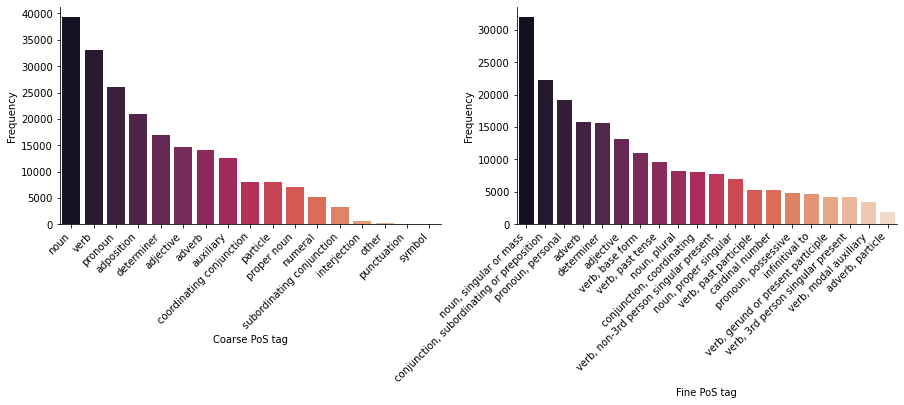

In [29]:
# plot all parts-of-speech tags created using the original text 
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
p = sns.barplot(ax=axs[0], x='description', y='original_text', data=coarse_pos_df, palette='rocket')
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)
p.set_xlabel("Coarse PoS tag")
p.set_ylabel("Frequency")
p.set_xticklabels(coarse_pos_df.description, rotation=45, ha='right')
data = fine_pos_df.head(20)
p2 = sns.barplot(ax=axs[1], x='description', y='original_text', data=data, palette='rocket')
p2.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.set_xlabel("Fine PoS tag")
p2.set_ylabel("Frequency")
p2.set_xticklabels(data.description, rotation=45, ha='right');

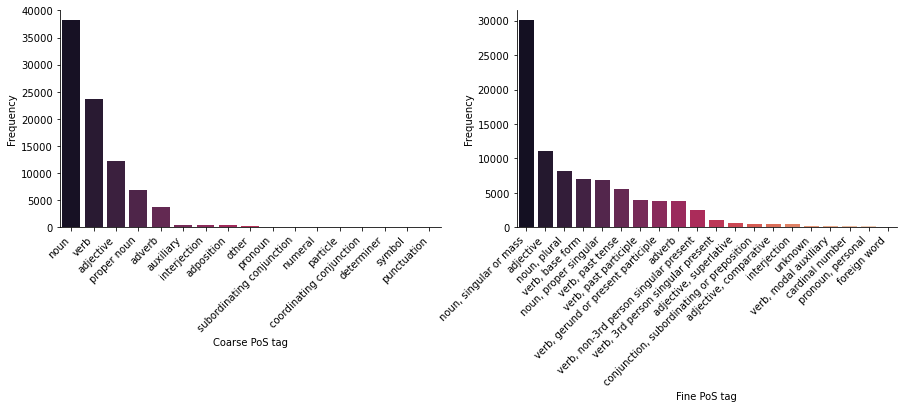

In [30]:
# plot all parts-of-speech tags created using the pre-processed text 
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
data = coarse_pos_df.sort_values(by=['preproc_text'], ascending=False)
p = sns.barplot(ax=axs[0], x='description', y='preproc_text', data=data, palette='rocket')
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)
p.set_xlabel("Coarse PoS tag")
p.set_ylabel("Frequency")
p.set_xticklabels(data.description, rotation=45, ha='right')
data = fine_pos_df.sort_values(by=['preproc_text'], ascending=False).head(20)
p2 = sns.barplot(ax=axs[1], x='description', y='preproc_text', data=data, palette='rocket')
p2.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.set_xlabel("Fine PoS tag")
p2.set_ylabel("Frequency")
p2.set_xticklabels(data.description, rotation=45, ha='right');

In [31]:
# count the number of entities detected
def count_ents(col):
    lol = vodafone_reviews[col]
    flat_list = [item for l in lol for item in l]
    freq = Counter(flat_list)
    df = pd.DataFrame.from_dict(freq, orient='index', columns=["count"])

    return df


ent_text_df = count_ents("ent_text").sort_values(by=['count'], ascending=False)
ent_label_df = count_ents("ent_label").sort_values(by=['count'], ascending=False)

In [32]:
ent_text_df.head(30)

,count
vodafone,1324
australia,129
vodaphone,98
first,94
telstra,90
5,57
50,52
3,52
one,49
english,49


In [33]:
ent_label_df

,count
ORG,1804
DATE,1357
CARDINAL,930
GPE,412
TIME,371
ORDINAL,187
QUANTITY,170
MONEY,122
PERSON,84
PRODUCT,79


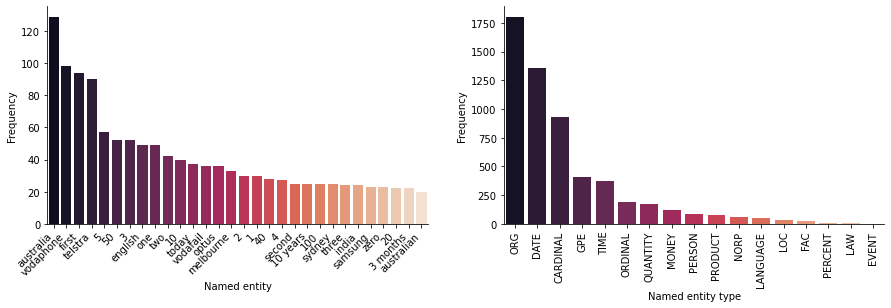

In [34]:
# and plot the dataframes; note that the word 'Vodafone', is excluded from the figure on the left as its frequency
#  is so high that the rest of the figure's values are obscured
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
data = ent_text_df.reset_index().sort_values(by=['count'], ascending=False)[1:31]
p = sns.barplot(ax=axs[0], x='index', y='count', data=data, palette='rocket')
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)
p.set_xlabel("Named entity")
p.set_ylabel("Frequency")
p.set_xticklabels(data['index'], rotation=45, ha='right')
data = ent_label_df.reset_index().sort_values(by=['count'], ascending=False)
p2 = sns.barplot(ax=axs[1], x='index', y='count', data=data, palette='rocket')
p2.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.set_xlabel("Named entity type")
p2.set_ylabel("Frequency")
p2.set_xticklabels(data['index'], rotation=90);

In [35]:
# define a function to create text corpora from selected columns
def create_review_corpora():
    review_corpus = vodafone_reviews.loc[:, ['score', 'nps_category', 'preproc_text',
                                             'preproc_bigrams', 'preproc_trigrams', 'preproc_lemma_phrases']]
    review_corpus['text_strings'] = review_corpus.preproc_text.apply(lambda x: ' '.join(x) if x != '' else x)
    review_corpus['bigram_strings'] = review_corpus.preproc_bigrams.apply(lambda x: ' '.join(x) if x != '' else x)
    review_corpus['trigram_strings'] = review_corpus.preproc_trigrams.apply(lambda x: ' '.join(x) if x != '' else x)
    review_corpus['noun_strings'] = review_corpus.preproc_lemma_phrases.apply(lambda x: ' '.join(x) if x != '' else x)

    promoter_corpus = review_corpus[review_corpus.nps_category == 'Promoter']
    passive_corpus = review_corpus[review_corpus.nps_category == 'Passive']
    detractor_corpus = review_corpus[review_corpus.nps_category == 'Detractor']

    return review_corpus, promoter_corpus, passive_corpus, detractor_corpus


# define a function to create the text format required for generating wordclouds
def generate_wordcloud_text(col_name='noun_strings'):
    all_text = ' '.join('' if pd.isna(review) else review for review in review_corpus[col_name])
    promoter_text = ' '.join('' if pd.isna(review) else review for review in promoter_corpus[col_name])
    passive_text = ' '.join('' if pd.isna(review) else review for review in passive_corpus[col_name])
    detractor_text = ' '.join('' if pd.isna(review) else review for review in detractor_corpus[col_name])

    return all_text, promoter_text, passive_text, detractor_text


review_corpus, promoter_corpus, passive_corpus, detractor_corpus = create_review_corpora()
all_text, promoter_text, passive_text, detractor_text = generate_wordcloud_text()

In [36]:
review_corpus.head()

,score,nps_category,preproc_text,preproc_bigrams,preproc_trigrams,preproc_lemma_phrases,text_strings,bigram_strings,trigram_strings,noun_strings
0,1,Detractor,"[vodaphone, ruin, life, steal, identity, secur...","[vodaphone, ruin, life, steal, identity, secur...","[vodaphone, ruin, life, steal, identity, secur...","[vodaphone, my_life, my_email, password, a_com...",vodaphone ruin life steal identity security em...,vodaphone ruin life steal identity security em...,vodaphone ruin life steal identity security em...,vodaphone my_life my_email password a_company_...
1,1,Detractor,"[misguided, sale, misguided, salecouple, day, ...","[misguided, sale, misguided, salecouple, day_a...","[misguided, sale, misguided, salecouple, day_a...","[day, 500_trade_in_value, my_old_phones, any_n...",misguided sale misguided salecouple day ago te...,misguided sale misguided salecouple day_ago te...,misguided sale misguided salecouple day_ago te...,day 500_trade_in_value my_old_phones any_new_p...
2,1,Detractor,"[bad, network, bad, network, datum, australia,...","[bad, network, bad, network, datum, australia,...","[bad, network, bad, network, datum, australia,...","[worst_network, worst_network, datum, australi...",bad network bad network datum australia vodafo...,bad network bad network datum australia vodafo...,bad network bad network datum australia vodafo...,worst_network worst_network datum australia vo...
3,1,Detractor,"[insurance, contract, bulshit, charge, year, p...","[insurance, contract, bulshit, charge, year, p...","[insurance, contract, bulshit, charge, year, p...","[insurance_contract, over_a_year, a_plan, insu...",insurance contract bulshit charge year plan in...,insurance contract bulshit charge year plan in...,insurance contract bulshit charge year plan in...,insurance_contract over_a_year a_plan insuranc...
4,1,Detractor,"[record, phonecall, issue, parent, vodafone, y...","[record, phonecall, issue, parent, vodafone, y...","[record, phonecall, issue, parent, vodafone, y...","[all_your_phonecall, issue, my_parent, vodafon...",record phonecall issue parent vodafone year s ...,record phonecall issue parent vodafone year s ...,record phonecall issue parent vodafone year s ...,all_your_phonecall issue my_parent vodafone ab...


In [37]:
all_text[0:1000]

'vodaphone my_life my_email password a_company_database_leak hacker my_vodaphone_account my_knowledge vodaphone 0_security place two_factor_authentication no_phone any_means 15_minute my_life my_phone my_sim these_fraudster the_vodaphone friday_afternoon my_number vodaphone_com a_store help my_password over_500_account my_phone the_two_factor_authentication tens_of_thousands dollar my_life my_identity every_account my_identy all_my_backup_passwords_recovery_keys the_event my_account day 500_trade_in_value my_old_phones any_new_phone 3_phone 2x_iphone_max 1x_samsung_note20 sale trade_in_app trade_in_reference_number trade_in_reference my_old_phone vodafone_sales_person new_samsung_s21 the_issue the_telecommunications_industry_ombudsman tio_vodafone_sales_team india worst_network worst_network datum australia vodafone mobile_phone datum my_home_wifi vodafone a_highway network call insurance_contract over_a_year a_plan insurance one_month_free_phone a_claim a_spare_phone my_one the_moment

In [38]:
# create the wordclouds
wc_stopwords = ['vodafone', 'vodaphone']
wordcloud_reviews = WordCloud(max_font_size=30, max_words=100000, random_state=2021, scale=2, background_color='white',
                              contour_width=3, stopwords=set(wc_stopwords), colormap='inferno').generate(all_text)

wc_stopwords = ['vodafone']
wordcloud_promoter_reviews = WordCloud(max_font_size=30, max_words=100000, random_state=2021, scale=2, 
                                       background_color='white', contour_width=3, stopwords=set(wc_stopwords),
                                       colormap='winter').generate(promoter_text)
wordcloud_passive_reviews = WordCloud(max_font_size=30, max_words=100000, random_state=2021, scale=2,
                                      background_color='white', contour_width=3, stopwords=set(wc_stopwords),
                                      colormap='summer').generate(passive_text)
wordcloud_detractor_reviews = WordCloud(max_font_size=30, max_words=100000, random_state=2021, scale=2,
                                        background_color='white', contour_width=3, stopwords=set(wc_stopwords),
                                        colormap='inferno').generate(detractor_text)

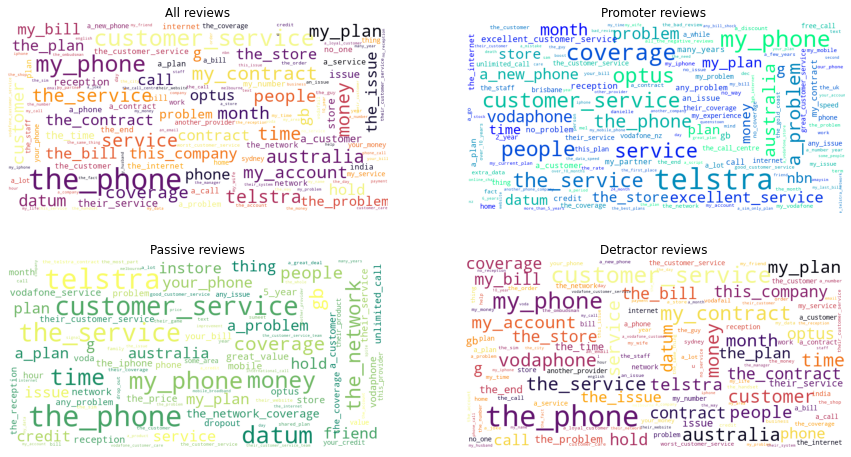

In [39]:
# plot the wordclouds
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs[0,0].imshow(wordcloud_reviews)
axs[0,0].set_title("All reviews")
axs[0,0].axis('off')
axs[0,1].imshow(wordcloud_promoter_reviews)
axs[0,1].set_title("Promoter reviews")
axs[0,1].axis('off')
axs[1,0].imshow(wordcloud_passive_reviews)
axs[1,0].set_title("Passive reviews")
axs[1,0].axis('off')
axs[1,1].imshow(wordcloud_detractor_reviews)
axs[1,1].set_title("Detractor reviews")
axs[1,1].axis('off');

In [40]:
# check associated word/phrase frequencies
def get_top_n_phrases(corpus, n=None):
    vec = CountVectorizer(stop_words=['vodafone']).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]


all_phrase_counts = get_top_n_phrases(review_corpus.noun_strings, 40)
all_phrase_counts_df = pd.DataFrame(all_phrase_counts, columns=['phrase', 'count'])

promoter_phrase_counts = get_top_n_phrases(promoter_corpus.noun_strings, 40)
promoter_phrase_counts_df = pd.DataFrame(promoter_phrase_counts, columns=['phrase', 'count'])

passive_phrase_counts = get_top_n_phrases(passive_corpus.noun_strings, 40)
passive_phrase_counts_df = pd.DataFrame(passive_phrase_counts, columns=['phrase', 'count'])

detractor_phrase_counts = get_top_n_phrases(detractor_corpus.noun_strings, 40)
detractor_phrase_counts_df = pd.DataFrame(detractor_phrase_counts, columns=['phrase', 'count'])

In [41]:
all_phrase_counts[0:10]

[('the_phone', 368),
 ('customer_service', 231),
 ('my_phone', 228),
 ('my_contract', 164),
 ('telstra', 157),
 ('money', 138),
 ('the_service', 138),
 ('australia', 137),
 ('service', 135),
 ('vodaphone', 129)]

In [42]:
all_phrase_counts_df.head(10)

,phrase,count
0,the_phone,368
1,customer_service,231
2,my_phone,228
3,my_contract,164
4,telstra,157
5,money,138
6,the_service,138
7,australia,137
8,service,135
9,vodaphone,129


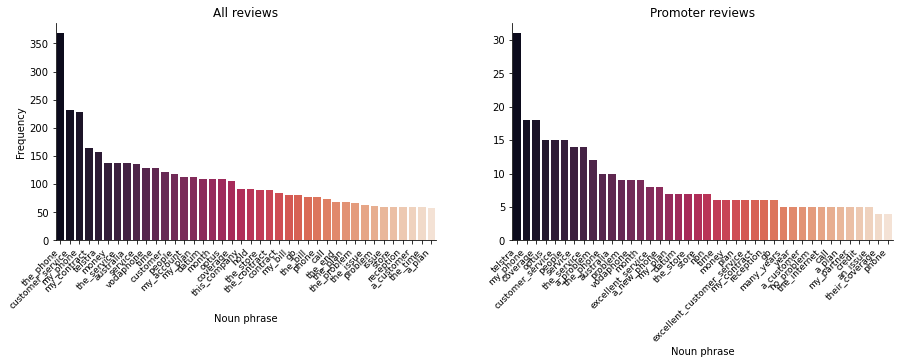

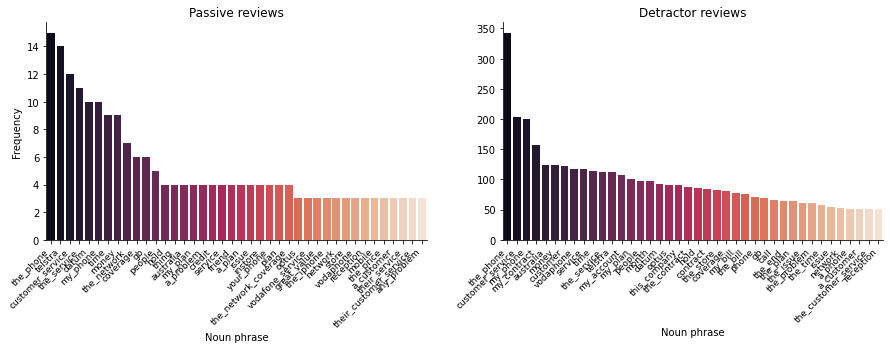

In [43]:
# plot the dataframes as bar charts
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
p = sns.barplot(ax=axs[0], x='phrase', y='count', data=all_phrase_counts_df, palette='rocket')
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)
p.set_xlabel("Noun phrase")
p.set_ylabel("Frequency")
p.set_title("All reviews")
p.set_xticklabels(all_phrase_counts_df.phrase, rotation=45, ha='right', fontsize=9)
p2 = sns.barplot(ax=axs[1], x='phrase', y='count', data=promoter_phrase_counts_df, palette='rocket')
p2.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.set_xlabel("Noun phrase")
p2.set_ylabel("")
p2.set_title("Promoter reviews")
p2.set_xticklabels(promoter_phrase_counts_df.phrase, rotation=45, ha='right', fontsize=9);

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
p3 = sns.barplot(ax=axs[0], x='phrase', y='count', data=passive_phrase_counts_df, palette='rocket')
p3.spines['right'].set_visible(False)
p3.spines['top'].set_visible(False)
p3.set_xlabel("Noun phrase")
p3.set_ylabel("Frequency")
p3.set_title("Passive reviews")
p3.set_xticklabels(passive_phrase_counts_df.phrase, rotation=45, ha='right', fontsize=9)
p4 = sns.barplot(ax=axs[1], x='phrase', y='count', data=detractor_phrase_counts_df, palette='rocket')
p4.spines['right'].set_visible(False)
p4.spines['top'].set_visible(False)
p4.set_xlabel("Noun phrase")
p4.set_ylabel("")
p4.set_title("Detractor reviews")
p4.set_xticklabels(detractor_phrase_counts_df.phrase, rotation=45, ha='right', fontsize=9);

In [44]:
# create new dataframe and calculate sentiment (polarity), subjectivity and classifications
sentiment_df = vodafone_reviews.loc[:, ['score', 'nps_category', 'text', 'clean_text']]
sentiment_df['text_strings'] = review_corpus.loc[:, ['text_strings']]

sentiment_df['text_polarity'] = sentiment_df.text.map(lambda x: TextBlob(x).sentiment.polarity)
sentiment_df['text_subjectivity'] = sentiment_df.text.map(lambda x: TextBlob(x).sentiment.subjectivity)
sentiment_df['clean_polarity'] = sentiment_df.clean_text.map(lambda x: TextBlob(x).sentiment.polarity)
sentiment_df['clean_subjectivity'] = sentiment_df.clean_text.map(lambda x: TextBlob(x).sentiment.subjectivity)

# classify the pattern analyser polarity scores
def classify_polarity(row):
    if row > 0:
        category = 'pos'
    elif row < 0:
        category = 'neg'
    else:
        category = 'neu'
        
    return category


sentiment_df['text_classification'] = sentiment_df.text_polarity.apply(classify_polarity)
sentiment_df['clean_classification'] = sentiment_df.clean_polarity.apply(classify_polarity)

In [45]:
sentiment_df.head()

,score,nps_category,text,clean_text,text_strings,text_polarity,text_subjectivity,clean_polarity,clean_subjectivity,text_classification,clean_classification
0,1,Detractor,Vodaphone Almost Ruined My Life - Stolen Ident...,vodaphone almost ruined my life stolen identit...,vodaphone ruin life steal identity security em...,0.065598,0.438889,0.055983,0.438889,pos,pos
1,1,Detractor,Misguided Sale. Misguided SaleCouple of days a...,misguided sale misguided salecouple of days ag...,misguided sale misguided salecouple day ago te...,0.106818,0.494156,0.106818,0.494156,pos,pos
2,1,Detractor,Worst network. Worst network for data in Austr...,worst network worst network for data in austra...,bad network bad network datum australia vodafo...,-0.575000,0.947222,-0.575000,0.947222,neg,neg
3,1,Detractor,Insurance contract with them is bulshit. They ...,insurance contract with them is bulshit they c...,insurance contract bulshit charge year plan in...,0.400000,0.600000,-0.066667,0.733333,pos,neg
4,1,Detractor,RECORD all your phonecalls with them when you ...,record all your phonecalls with them when you ...,record phonecall issue parent vodafone year s ...,-0.004861,0.383611,0.001389,0.383611,neg,pos


In [46]:
# compare results against customer rating and nps category
rating_cm = pd.crosstab(sentiment_df.score, sentiment_df.text_classification, rownames=['Customer rating'], colnames=['Textblob'])
nps_cm = pd.crosstab(sentiment_df.nps_category, sentiment_df.text_classification, rownames=['NPS category'], colnames=['Textblob'])

In [47]:
rating_cm

Textblob,neg,neu,pos
Customer rating,,,
1,1029,44,429
2,58,1,51
3,9,2,44
4,1,0,81
5,5,2,147


In [48]:
nps_cm

Textblob,neg,neu,pos
NPS category,,,
Detractor,1096,47,524
Passive,1,0,81
Promoter,5,2,147


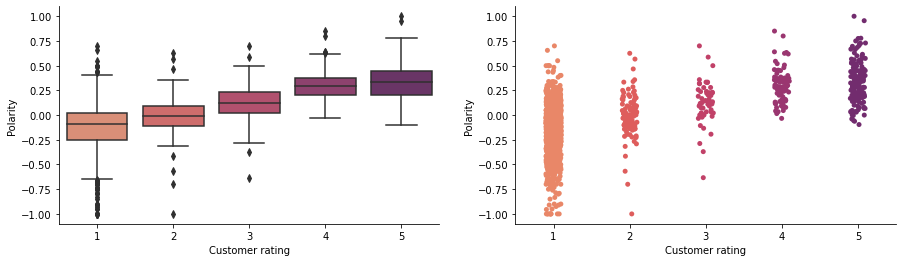

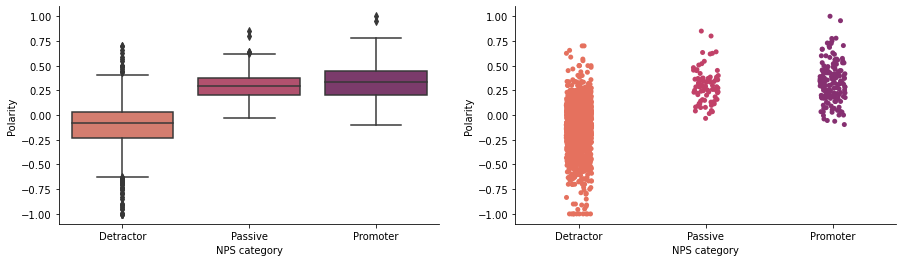

In [49]:
# plot polarity by customer rating and NPS category
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
p = sns.boxplot(ax=axs[0], x='score', y='text_polarity', data=sentiment_df, palette='flare')
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)
p.set_xlabel("Customer rating")
p.set_ylabel("Polarity");
p2 = sns.stripplot(ax=axs[1], x='score', y='text_polarity', data=sentiment_df, palette='flare')
p2.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.set_xlabel("Customer rating")
p2.set_ylabel("Polarity");

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
p3 = sns.boxplot(ax=axs[0], x='nps_category', y='text_polarity', data=sentiment_df, palette='flare')
p3.spines['right'].set_visible(False)
p3.spines['top'].set_visible(False)
p3.set_xlabel("NPS category")
p3.set_ylabel("Polarity");
p4 = sns.stripplot(ax=axs[1], x='nps_category', y='text_polarity', data=sentiment_df, palette='flare')
p4.spines['right'].set_visible(False)
p4.spines['top'].set_visible(False)
p4.set_xlabel("NPS category")
p4.set_ylabel("Polarity");

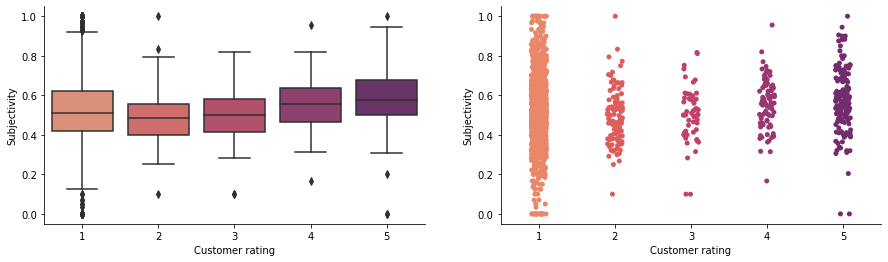

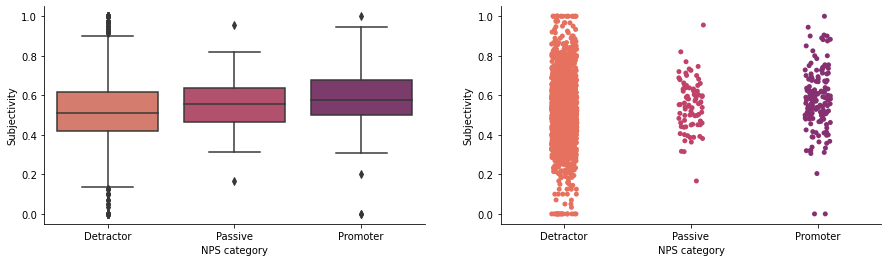

In [50]:
# plot subjectivity by customer rating and NPS category
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
p = sns.boxplot(ax=axs[0], x='score', y='text_subjectivity', data=sentiment_df, palette='flare')
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)
p.set_xlabel("Customer rating")
p.set_ylabel("Subjectivity");
p2 = sns.stripplot(ax=axs[1], x='score', y='text_subjectivity', data=sentiment_df, palette='flare')
p2.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.set_xlabel("Customer rating")
p2.set_ylabel("Subjectivity");

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
p3 = sns.boxplot(ax=axs[0], x='nps_category', y='text_subjectivity', data=sentiment_df, palette='flare')
p3.spines['right'].set_visible(False)
p3.spines['top'].set_visible(False)
p3.set_xlabel("NPS category")
p3.set_ylabel("Subjectivity");
p4 = sns.stripplot(ax=axs[1], x='nps_category', y='text_subjectivity', data=sentiment_df, palette='flare')
p4.spines['right'].set_visible(False)
p4.spines['top'].set_visible(False)
p4.set_xlabel("NPS category")
p4.set_ylabel("Subjectivity");

In [51]:
# create some descriptive statistics
polarity_stats_by_rating = sentiment_df.groupby('score')['text_polarity'].agg([np.mean, np.std, np.min, np.max, np.median])
polarity_stats_by_nps = sentiment_df.groupby('nps_category')['text_polarity'].agg([np.mean, np.std, np.min, np.max, np.median])

subjectivity_stats_by_rating = sentiment_df.groupby('score')['text_subjectivity'].agg([np.mean, np.std, np.min, np.max, np.median])
subjectivity_stats_by_nps = sentiment_df.groupby('nps_category')['text_subjectivity'].agg([np.mean, np.std, np.min, np.max, np.median])

In [52]:
polarity_stats_by_rating

,mean,std,amin,amax,median
score,,,,,
1,-0.126736,0.232654,-1.000000,0.700,-0.095035
2,-0.009457,0.214163,-1.000000,0.625,-0.009762
3,0.126605,0.213699,-0.633333,0.700,0.126667
4,0.301870,0.168784,-0.033400,0.850,0.290643
5,0.342591,0.204497,-0.095833,1.000,0.336667


In [53]:
polarity_stats_by_nps

,mean,std,amin,amax,median
nps_category,,,,,
Detractor,-0.110639,0.236677,-1.000000,0.70,-0.080000
Passive,0.301870,0.168784,-0.033400,0.85,0.290643
Promoter,0.342591,0.204497,-0.095833,1.00,0.336667


In [54]:
subjectivity_stats_by_rating

,mean,std,amin,amax,median
score,,,,,
1,0.522756,0.172631,0.000000,1.000000,0.512293
2,0.495017,0.135196,0.100000,1.000000,0.485830
3,0.504026,0.140942,0.100000,0.816667,0.501302
4,0.553080,0.126401,0.166667,0.955556,0.555542
5,0.579743,0.159576,0.000000,1.000000,0.576786


In [55]:
subjectivity_stats_by_nps

,mean,std,amin,amax,median
nps_category,,,,,
Detractor,0.520307,0.169547,0.000000,1.000000,0.511111
Passive,0.553080,0.126401,0.166667,0.955556,0.555542
Promoter,0.579743,0.159576,0.000000,1.000000,0.576786


In [56]:
# save all objects created in this section
def save_created_objects3():
    object_names = [review_corpus, promoter_corpus, passive_corpus, detractor_corpus,
                    all_text, promoter_text, passive_text, detractor_text,
                    all_phrase_counts_df, promoter_phrase_counts_df, passive_phrase_counts_df,
                    detractor_phrase_counts_df,
                    vodafone_reviews,
                    sentiment_df, polarity_stats_by_rating, polarity_stats_by_nps,
                    subjectivity_stats_by_rating, subjectivity_stats_by_nps,
                    rating_cm, nps_cm]

    all_phrase_counts_df.to_csv('part4_all_phrase_counts_df.csv', header=True)
    promoter_phrase_counts_df.to_csv('part4_promoter_phrase_counts_df.csv', header=True)
    passive_phrase_counts_df.to_csv('part4_passive_phrase_counts_df.csv', header=True)
    detractor_phrase_counts_df.to_csv('part4_detractor_phrase_counts_df.csv', header=True)
    sentiment_df.to_csv('part4_sentiment_df.csv', header=True)
    polarity_stats_by_rating.to_csv('part4_polarity_stats_by_rating.csv', header=True, index=True)
    polarity_stats_by_nps.to_csv('part4_polarity_stats_by_nps.csv', header=True, index=True)
    subjectivity_stats_by_rating.to_csv('part4_subjectivity_stats_by_rating.csv', header=True, index=True)
    subjectivity_stats_by_nps.to_csv('part4_subjectivity_stats_by_nps.csv', header=True, index=True)
    rating_cm.to_csv('part4_rating_cm.csv', header=True, index=True)
    nps_cm.to_csv('part4_nps_cm.csv', header=True, index=True)

    with open('part4_review_corpus', 'wb') as outfile:
        pickle.dump(review_corpus, outfile)
    outfile.close()

    with open('part4_promoter_corpus', 'wb') as outfile:
        pickle.dump(promoter_corpus, outfile)
    outfile.close()

    with open('part4_passive_corpus', 'wb') as outfile:
        pickle.dump(passive_corpus, outfile)
    outfile.close()

    with open('part4_detractor_corpus', 'wb') as outfile:
        pickle.dump(detractor_corpus, outfile)
    outfile.close()

    with open('part4_all_text', 'wb') as outfile:
        pickle.dump(all_text, outfile)
    outfile.close()

    with open('part4_promoter_text', 'wb') as outfile:
        pickle.dump(promoter_text, outfile)
    outfile.close()

    with open('part4_passive_text', 'wb') as outfile:
        pickle.dump(passive_text, outfile)
    outfile.close()

    with open('part4_detractor_text', 'wb') as outfile:
        pickle.dump(detractor_text, outfile)
    outfile.close()

    with open('part4_vodafone_reviews', 'wb') as outfile:
        pickle.dump(vodafone_reviews, outfile)
    outfile.close()

    
save_created_objects3()